In [1]:
import os
import re
import json
from pathlib import Path
from IPython.display import display

import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

sns.set_theme()
sns.set_context("notebook", font_scale=0.8) 

%config InlineBackend.figure_format = 'retina'  
%config InlineBackend.print_figure_kwargs = {'dpi': 170}  

In [2]:
data_dir = Path('Data')
output_dir = Path('Output')
output_dir.mkdir(exist_ok=True)

In [3]:
clemrun_dir = Path('/Users/nidhirbhavsar/Desktop/WORK/Clembench/clembench-runs/')
clemb_dir = Path('/Users/nidhirbhavsar/Desktop/WORK/Clembench/clembench/')

In [4]:
def load_clemb_version(version):
    """Load and preprocess clembench results for a specific version"""
    df = pd.read_csv(clemrun_dir / f'{version}/results.csv')
    df = df.rename(columns={df.columns[0]: 'models'})
    df = df.set_index('models')
    return df

clemb_v0 = load_clemb_version('v0.9')
clemb_v1 = load_clemb_version('v1.0')
clemb_v2 = load_clemb_version('v1.6')

score_col = clemb_v1.columns[0]
played_col = clemb_v1.columns[1]
quality_col = clemb_v1.columns[2]

common_models_v1v2 = set(clemb_v1.index).intersection(set(clemb_v2.index))

In [5]:
common_models_v1v2

{'CodeLlama-34b-Instruct-hf-t0.0--CodeLlama-34b-Instruct-hf-t0.0',
 'Mistral-7B-Instruct-v0.1-t0.0--Mistral-7B-Instruct-v0.1-t0.0',
 'Mixtral-8x7B-Instruct-v0.1-t0.0--Mixtral-8x7B-Instruct-v0.1-t0.0',
 'SUS-Chat-34B-t0.0--SUS-Chat-34B-t0.0',
 'WizardLM-13b-v1.2-t0.0--WizardLM-13b-v1.2-t0.0',
 'WizardLM-70b-v1.0-t0.0--WizardLM-70b-v1.0-t0.0',
 'Yi-34B-Chat-t0.0--Yi-34B-Chat-t0.0',
 'claude-2.1-t0.0--claude-2.1-t0.0',
 'gpt-4-0613-t0.0--gpt-4-0613-t0.0',
 'gpt-4-1106-preview-t0.0--gpt-4-1106-preview-t0.0',
 'llama-2-70b-chat-hf-t0.0--llama-2-70b-chat-hf-t0.0',
 'openchat-3.5-0106-t0.0--openchat-3.5-0106-t0.0',
 'openchat-3.5-1210-t0.0--openchat-3.5-1210-t0.0',
 'openchat_3.5-t0.0--openchat_3.5-t0.0',
 'sheep-duck-llama-2-13b-t0.0--sheep-duck-llama-2-13b-t0.0',
 'sheep-duck-llama-2-70b-v1.1-t0.0--sheep-duck-llama-2-70b-v1.1-t0.0',
 'tulu-2-dpo-70b-t0.0--tulu-2-dpo-70b-t0.0',
 'vicuna-13b-v1.5-t0.0--vicuna-13b-v1.5-t0.0',
 'vicuna-33b-v1.3-t0.0--vicuna-33b-v1.3-t0.0'}

In [6]:
clemb_v2.index = clemb_v2.index.map(lambda x: re.sub(r'(\w*)-t0.0.*', r'\1', x).lower())
clemb_v1.index = clemb_v1.index.map(lambda x: re.sub(r'(\w*)-t0.0.*', r'\1', x).lower())

Remove specific model combinations from v0.9

In [7]:
models_to_drop = [
    'gpt-3.5-turbo-t0.0--gpt-4-t0.0',
    'gpt-4-t0.0--gpt-3.5-turbo-t0.0'
]
clemb_v0 = clemb_v0.drop(axis=0, labels=models_to_drop)
clemb_v0.index = clemb_v0.index.map(lambda x: re.sub(r'(\w*)-t0.0.*', r'\1', x).lower())

In [8]:
clemb_v0.index

Index(['claude-v1.3', 'falcon-40b', 'gpt-3.5-turbo', 'gpt-4', 'koala-13b',
       'luminous-supreme', 'oasst-12b', 'text-davinci-003', 'vicuna-13b'],
      dtype='object', name='models')

### Tracking the Evolution of the Benchmark (& of the tested models)

In [9]:
print(f"Shapes - v0.9: {clemb_v0.shape}, v1.0: {clemb_v1.shape}, v1.6: {clemb_v2.shape}")

Shapes - v0.9: (9, 24), v1.0: (41, 24), v1.6: (72, 24)


##### v2 = v2.0

In [10]:
sorted_scores_v2 = clemb_v2.loc[:,score_col].sort_values(ascending=False)
sorted_scores_v2

models
o1-preview-2024-09-12                 73.63
gpt-4-turbo-2024-04-09                58.30
claude-3-5-sonnet-20240620            57.08
gpt-4-0125-preview                    52.50
meta-llama-3.1-405b-instruct-turbo    52.11
                                      ...  
qwen1.5-7b-chat                        2.58
gemma-7b-it                            1.82
llama-2-70b-chat-hf                    0.81
qwen1.5-0.5b-chat                      0.12
qwen1.5-1.8b-chat                      0.00
Name: -, clemscore, Length: 72, dtype: float64

In [11]:
clemb_v2 = clemb_v2[~clemb_v2.index.str.contains('anyscale')].copy(deep=True)

In [12]:
clemb_v2.index = clemb_v2.index.map(lambda x: re.sub(r'meta-(\w*)', r'\1', x))  
clemb_v2.index = clemb_v2.index.map(lambda x: re.sub(r'(\w*)-hf', r'\1', x))    

In [13]:
v2_models = clemb_v2.index.tolist()

In [14]:
v2_models

['codellama-34b-instruct',
 'llama-3.1-nemotron-70b-instruct',
 'llama-3-70b-instruct',
 'llama-3-8b-instruct',
 'llama-3.1-405b-instruct-turbo',
 'llama-3.1-70b-instruct',
 'llama-3.1-8b-instruct',
 'mistral-7b-instruct-v0.1',
 'mistral-7b-instruct-v0.2',
 'mistral-large-instruct-2407',
 'mixtral-8x22b-instruct-v0.1',
 'mixtral-8x7b-instruct-v0.1',
 'nous-hermes-2-mixtral-8x7b-sft',
 'phi-3-mini-128k-instruct',
 'qwen1.5-0.5b-chat',
 'qwen1.5-1.8b-chat',
 'qwen1.5-14b-chat',
 'qwen1.5-32b-chat',
 'qwen1.5-72b-chat',
 'qwen1.5-7b-chat',
 'qwen2-72b-instruct',
 'qwen2-7b-instruct',
 'qwen2.5-coder-32b-instruct',
 'sus-chat-34b',
 'starling-lm-7b-beta',
 'wizardlm-13b-v1.2',
 'wizardlm-70b-v1.0',
 'yi-1.5-34b-chat',
 'yi-1.5-6b-chat',
 'yi-1.5-9b-chat',
 'yi-34b-chat',
 'aya-23-35b',
 'aya-23-8b',
 'claude-2.1',
 'claude-3-5-sonnet-20240620',
 'claude-3-haiku-20240307',
 'claude-3-opus-20240229',
 'claude-3-sonnet-20240229',
 'codegemma-7b-it',
 'command-r-plus',
 'command-r',
 'dolphin-

In [15]:
v2_open = [
    'aya-23-35b',
    'aya-23-8b',
    'codegemma-7b-it',
    'codellama-34b-instruct',
    'command-r',
    'command-r-plus',
    'dolphin-2.5-mixtral-8x7b',
    'gemma-1.1-2b-it',
    'gemma-1.1-7b-it',
    'gemma-2-27b-it',
    'gemma-2-2b-it',
    'gemma-2-9b-it',
    'gemma-7b-it',
    'gpt-4o-mini-2024-07-18',
    'llama-2-70b-chat',
    'llama-3-70b-instruct',
    'llama-3-8b-instruct',
    'llama-3.1-405b-instruct-turbo',
    'llama-3.1-70b-instruct',
    'llama-3.1-8b-instruct',
    'llama-3.1-nemotron-70b-instruct',
    'mistral-7b-instruct-v0.1',
    'mistral-7b-instruct-v0.2',
    'mistral-large-2402',
    'mistral-large-instruct-2407',
    'mistral-medium-2312',
    'mixtral-8x22b-instruct-v0.1',
    'mixtral-8x7b-instruct-v0.1',
    'nous-hermes-2-mixtral-8x7b-sft',
    'o1-preview-2024-09-12',
    'openchat-3.5-0106',
    'openchat-3.5-1210',
    'openchat_3.5',
    'phi-3-mini-128k-instruct',
    'qwen1.5-0.5b-chat',
    'qwen1.5-1.8b-chat',
    'qwen1.5-14b-chat',
    'qwen1.5-32b-chat',
    'qwen1.5-72b-chat',
    'qwen1.5-7b-chat',
    'qwen2-72b-instruct',
    'qwen2-7b-instruct',
    'qwen2.5-coder-32b-instruct',
    'salamandra-7b-instruct',
    'sheep-duck-llama-2-13b',
    'sheep-duck-llama-2-70b-v1.1',
    'starling-lm-7b-beta',
    'sus-chat-34b',
    'tulu-2-dpo-70b',
    'vicuna-13b-v1.5',
    'vicuna-33b-v1.3',
    'wizardlm-13b-v1.2',
    'wizardlm-70b-v1.0',
    'yi-1.5-34b-chat',
    'yi-1.5-6b-chat',
    'yi-1.5-9b-chat',
    'yi-34b-chat'
]

In [16]:
v2_closed = set(clemb_v2.index.tolist()) - set(v2_open)

In [17]:
v2_closed

{'claude-2.1',
 'claude-3-5-sonnet-20240620',
 'claude-3-haiku-20240307',
 'claude-3-opus-20240229',
 'claude-3-sonnet-20240229',
 'gemini-1.0-pro',
 'gemini-1.5-flash-latest',
 'gemini-1.5-pro-latest',
 'gpt-3.5-turbo-0125',
 'gpt-4-0125-preview',
 'gpt-4-0613',
 'gpt-4-1106-preview',
 'gpt-4-turbo-2024-04-09',
 'gpt-4o-2024-05-13',
 'gpt-4o-2024-08-06'}

In [18]:
# clemb_v2.loc[:, 'ow/gt'] = '🔓'
# clemb_v2.loc[clemb_v2.index.isin(v2_closed), 'ow/gt'] = '🔑'

## Maybe for screenshots for social media...
#clemb_v2.loc[:, 'ow/gt'] = '🏋🏽‍♀️'
#clemb_v2.loc[clemb_v2.index.isin(v2_closed), 'ow/gt'] = '🔒'#

clemb_v2.loc[:, 'model_type'] = 'ow'  
clemb_v2.loc[clemb_v2.index.isin(v2_closed), 'model_type'] = '$$'  

In [19]:
clemb_v2.sort_values(by=score_col, ascending=False)[[score_col, 'model_type']]

,"-, clemscore",model_type
models,,
o1-preview-2024-09-12,73.63,ow
gpt-4-turbo-2024-04-09,58.30,$$
claude-3-5-sonnet-20240620,57.08,$$
gpt-4-0125-preview,52.50,$$
llama-3.1-405b-instruct-turbo,52.11,ow
...,...,...
qwen1.5-7b-chat,2.58,ow
gemma-7b-it,1.82,ow
llama-2-70b-chat,0.81,ow


Distance best open (meta-llama-3.1-405b-instruct-turbo) to best closed (o1-preview-2024-09-12)

In [20]:
73.63 - 52.11

21.519999999999996

In [21]:
score_threshold = 16
v2_high_scores = (clemb_v2.loc[clemb_v2[score_col] > score_threshold]
                 .sort_values(by=score_col, ascending=False)
                 [[score_col, 'model_type']])

In [22]:
v2_high_scores.to_latex(
    output_dir / 'v1.6-score-table.tex',
    header=['sc', 'o/g'],
    float_format="%.2f"
)

Note: The LaTeX needs to be edited manually, as it is impossible to put the index label on the header row using .to_latex()

```
\begin{tabular}[t]{lrl}
\toprule
models &    sc & o/g \\
\midrule
```

##### v1 = v1.0

In [23]:
v1_models = clemb_v1.index.tolist()
v1_models

['codellama-34b-instruct-hf',
 'mistral-7b-instruct-v0.1',
 'mixtral-8x7b-instruct-v0.1',
 'nous-hermes-2-mixtral-8x7b-dpo',
 'sus-chat-34b',
 'wizard-vicuna-13b-uncensored-hf',
 'wizardlm-13b-v1.2',
 'wizardlm-70b-v1.0',
 'yi-34b-chat',
 'claude-2',
 'claude-2.1',
 'claude-instant-1.2',
 'claude-v1.3',
 'command',
 'deepseek-llm-67b-chat',
 'deepseek-llm-7b-chat',
 'falcon-7b-instruct',
 'gpt-3.5-turbo-0613',
 'gpt-3.5-turbo-1106',
 'gpt-4-0314',
 'gpt-4-0613',
 'gpt-4-1106-preview',
 'gpt4all-13b-snoozy',
 'koala-13b-hf',
 'llama-2-13b-chat-hf',
 'llama-2-70b-chat-hf',
 'llama-2-7b-chat-hf',
 'mistral-medium',
 'oasst-sft-4-pythia-12b-epoch-3.5',
 'openchat-3.5-0106',
 'openchat-3.5-1210',
 'openchat_3.5',
 'sheep-duck-llama-2-13b',
 'sheep-duck-llama-2-70b-v1.1',
 'tulu-2-dpo-70b',
 'tulu-2-dpo-7b',
 'vicuna-13b-v1.5',
 'vicuna-33b-v1.3',
 'vicuna-7b-v1.5',
 'zephyr-7b-alpha',
 'zephyr-7b-beta']

In [24]:
v1_open = [
    'codellama-34b-instruct-hf',
    'mistral-7b-instruct-v0.1',
    'mixtral-8x7b-instruct-v0.1',
    'nous-hermes-2-mixtral-8x7b-dpo',
    'sus-chat-34b',
    'wizard-vicuna-13b-uncensored-hf',
    'wizardlm-13b-v1.2',
    'wizardlm-70b-v1.0',
    'yi-34b-chat',
    'deepseek-llm-67b-chat',
    'deepseek-llm-7b-chat',
    'falcon-7b-instruct',
    'koala-13b-hf',
    'llama-2-13b-chat-hf',
    'llama-2-70b-chat-hf',
    'llama-2-7b-chat-hf',
    'mistral-medium',
    'oasst-sft-4-pythia-12b-epoch-3.5',
    'openchat-3.5-0106',
    'openchat-3.5-1210',
    'openchat_3.5',
    'sheep-duck-llama-2-13b',
    'sheep-duck-llama-2-70b-v1.1',
    'tulu-2-dpo-70b',
    'tulu-2-dpo-7b',
    'vicuna-13b-v1.5',
    'vicuna-33b-v1.3',
    'vicuna-7b-v1.5',
    'zephyr-7b-alpha',
    'zephyr-7b-beta'
]

In [25]:
v1_closed = set(clemb_v1.index.tolist()) - set(v1_open)

In [26]:
v1_closed

{'claude-2',
 'claude-2.1',
 'claude-instant-1.2',
 'claude-v1.3',
 'command',
 'gpt-3.5-turbo-0613',
 'gpt-3.5-turbo-1106',
 'gpt-4-0314',
 'gpt-4-0613',
 'gpt-4-1106-preview',
 'gpt4all-13b-snoozy'}

In [27]:
#clemb_v1.loc[:, 'ow/gt'] = '🔒'
#clemb_v1.loc[clemb_v1.index.isin(v1_open), 'ow/gt'] = '🏋'

clemb_v1.loc[:, 'model_type'] = '$$'
clemb_v1.loc[clemb_v1.index.isin(v1_open), 'model_type'] = 'ow'

In [28]:
clemb_v1.sort_values(by=score_col, ascending=False)[[score_col, 'model_type']]

,"-, clemscore",model_type
models,,
gpt-4-0613,60.90,$$
gpt-4-1106-preview,60.33,$$
gpt-4-0314,58.81,$$
claude-v1.3,37.64,$$
claude-2.1,36.38,$$
claude-2,33.71,$$
gpt-3.5-turbo-0613,32.53,$$
gpt-3.5-turbo-1106,30.45,$$
openchat_3.5,19.72,ow


Distance best open (openchat_3.5) to best closed (gpt-4-0613	

In [29]:
60.90 - 19.72

41.18

Do I even need to cap this? .... I leave it at 15 for now, even though v1.6 is capped at 15...

In [30]:
score_threshold = 15  # Different threshold than v2
v1_high_scores = (clemb_v1.loc[clemb_v1[score_col] > score_threshold]
                 .sort_values(by=score_col, ascending=False)
                 [[score_col, 'model_type']])

In [31]:
v1_high_scores.to_latex(
    output_dir / 'v1.0-score-table.tex',
    header=['sc', 'o/g'],
    float_format="%.2f"
)

Note: The LaTeX output needs manual editing to match this format:
```
\\begin{tabular}[t]{lrl}
\\toprule
models &    sc & o/g \\\\
\\midrule
```

##### v0 = v0.9

In [32]:
v0_models = clemb_v0.index.tolist()
v0_models

['claude-v1.3',
 'falcon-40b',
 'gpt-3.5-turbo',
 'gpt-4',
 'koala-13b',
 'luminous-supreme',
 'oasst-12b',
 'text-davinci-003',
 'vicuna-13b']

In [33]:
v0_closed = [
    'claude-v1.3',
    'gpt-3.5-turbo',
    'gpt-4',
    'luminous-supreme',
    'text-davinci-003',
]

In [34]:
v0_open = set(clemb_v0.index.tolist()) - set(v0_closed)

In [35]:
#clemb_v0.loc[:, 'ow/gt'] = '🏋🏽‍♀️'
#clemb_v0.loc[clemb_v0.index.isin(v0_closed), 'ow/gt'] = '🔒'

clemb_v0.loc[:, 'model_type'] = 'ow'
clemb_v0.loc[clemb_v0.index.isin(v0_closed), 'model_type'] = '$$'

In [36]:
clemb_v0.sort_values(by=score_col, ascending=False)[[score_col, 'model_type']]

,"-, clemscore",model_type
models,,
gpt-4,59.49,$$
claude-v1.3,37.07,$$
gpt-3.5-turbo,37.02,$$
text-davinci-003,15.78,$$
vicuna-13b,4.24,ow
oasst-12b,1.74,ow
koala-13b,1.48,ow
falcon-40b,0.71,ow
luminous-supreme,0.00,$$


Distance best open (vicuna-13b) to best closed (gpt-4)

In [37]:
59.49 - 4.24

55.25

In [38]:
v0_high_scores = clemb_v0.sort_values(by=score_col, ascending=False)[[score_col, 'model_type']]

In [39]:
v0_high_scores.to_latex(
    output_dir / 'v0.9-score-table.tex',
    header=['sc', 'o/g'],
    float_format="%.2f"
)

### For the Appendix!

In [40]:
latex_params = {
    'header': ['sc', '%pl', 'qs', 'o/g'],
    'float_format': "%.2f"
}

# v1.6 full table
v2_full = clemb_v2.iloc[:,[0,1,2,-1]].sort_values(by=score_col, ascending=False)
v2_full.to_latex(
    output_dir / 'v1.6-full-table.tex',
    **latex_params
)

# v1.0 full table
v1_full = clemb_v1.iloc[:,[0,1,2,-1]].sort_values(by=score_col, ascending=False)
v1_full.to_latex(
    output_dir / 'v1.0-full-table.tex',
    **latex_params
)

# v0.9 full table
v0_full = clemb_v0.iloc[:,[0,1,2,-1]].sort_values(by=score_col, ascending=False)
v0_full.to_latex(
    output_dir / 'v0.9-full-table.tex',
    **latex_params
)

In [41]:
clemb_v2.head()

,"-, clemscore","all, Average % Played","all, Average Quality Score","imagegame, % Played","imagegame, Quality Score","imagegame, Quality Score (std)","privateshared, % Played","privateshared, Quality Score","privateshared, Quality Score (std)","referencegame, % Played","referencegame, Quality Score","referencegame, Quality Score (std)","taboo, % Played","taboo, Quality Score","taboo, Quality Score (std)","wordle, % Played","wordle, Quality Score","wordle, Quality Score (std)","wordle_withclue, % Played","wordle_withclue, Quality Score","wordle_withclue, Quality Score (std)","wordle_withcritic, % Played","wordle_withcritic, Quality Score","wordle_withcritic, Quality Score (std)",model_type
models,,,,,,,,,,,,,,,,,,,,,,,,,
codellama-34b-instruct,14.35,33.57,42.76,0.0,NaN,NaN,0.0,NaN,NaN,100.0,94.44,22.97,51.67,51.61,50.80,56.67,0.00,0.00,26.67,25.00,46.29,0.00,NaN,NaN,ow
llama-3.1-nemotron-70b-instruct,10.16,20.76,48.92,0.0,NaN,NaN,92.0,78.85,15.63,30.0,90.74,29.26,3.33,50.00,70.71,0.00,NaN,NaN,3.33,0.00,NaN,16.67,25.00,43.30,ow
llama-3-70b-instruct,35.11,80.72,43.50,0.0,NaN,NaN,100.0,84.37,13.69,100.0,64.44,48.00,91.67,70.30,39.37,90.00,1.85,6.81,96.67,14.37,32.34,86.67,25.64,39.08,ow
llama-3-8b-instruct,19.99,76.10,26.27,0.0,NaN,NaN,96.0,58.91,30.05,100.0,46.11,49.99,100.00,37.78,45.08,86.67,0.00,0.00,83.33,14.00,33.91,66.67,0.83,3.73,ow
llama-3.1-405b-instruct-turbo,52.11,90.12,57.82,62.5,94.12,12.55,100.0,84.24,29.65,100.0,80.00,40.11,95.00,76.61,36.03,93.33,7.14,12.72,93.33,29.70,34.87,86.67,32.95,35.63,ow


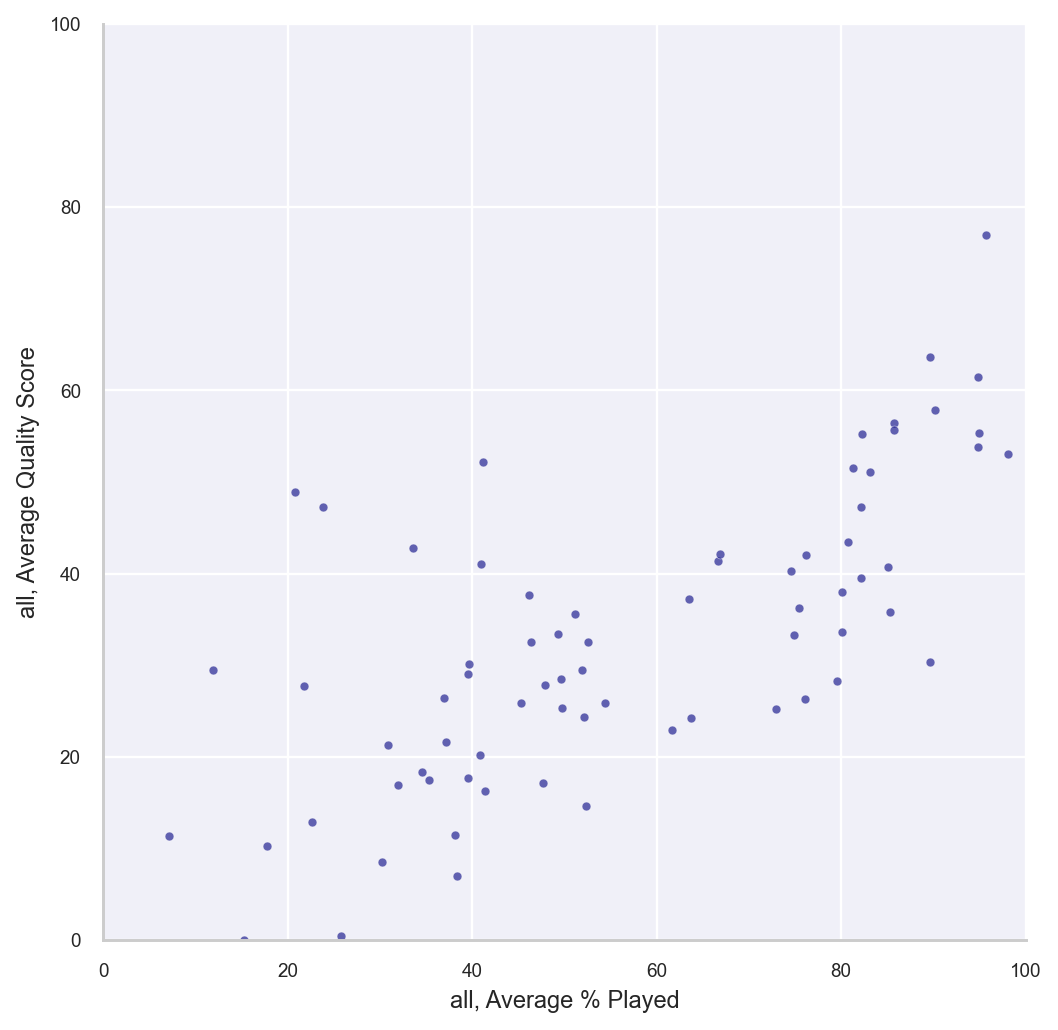

In [42]:
sns.set_style("whitegrid", {
    'axes.facecolor': '#F0F0F8',
    'grid.color': 'white',
    'grid.linestyle': '-',
    'grid.linewidth': 1
})

plt.figure(figsize=(7, 7))
sns.scatterplot(
    data=clemb_v2,
    x=played_col,
    y=quality_col,
    s=14,          
    color='navy',  
    alpha=0.6      
)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel(played_col, fontsize=10)
plt.ylabel(quality_col, fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
sns.despine()
plt.show()